In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm

import matplotlib.pyplot as plt

import os, sys
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import jax
import jax.numpy as jnp
from functools import partial
import emcee
jax.config.update("jax_enable_x64", True)

import saqqara
import sys
sys.path.insert(0, '../inference/')
sys.path.insert(0, '../simulator/')
from networks import SignalAET
from simulator import LISA_AET
from dataloader import get_datasets, setup_dataloaders, get_data_npy_dataset, get_resampling_dataloader
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import pickle
import swyft
import logging
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
config = glob.glob(f"../training_dir/*OJUU*.yaml")[0]
settings = saqqara.load_settings(config_path=config)
low_cg_sim = LISA_AET(settings)

Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete


In [6]:
data_sample = low_cg_sim.sample()

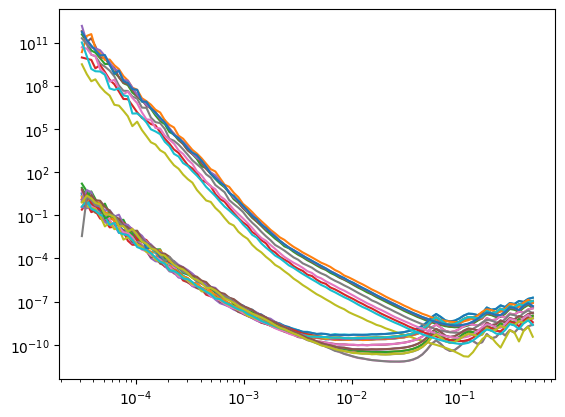

In [7]:
for _ in range(10):
    data_sample = low_cg_sim.sample()
    plt.loglog(low_cg_sim.coarse_grained_f, data_sample["full_coarse_grained_data"])

In [8]:
config = glob.glob(f"../training_dir/*G7RG*.yaml")[0]
settings = saqqara.load_settings(config_path=config)
high_cg_sim = LISA_AET(settings)

Detector setup complete
Noise matrices computed
Response computed
Coarse graining setup complete


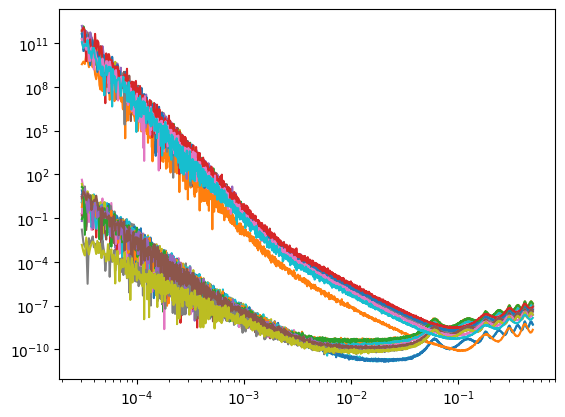

In [9]:
for _ in range(10):
    data_sample = high_cg_sim.sample()
    plt.loglog(high_cg_sim.coarse_grained_f, data_sample["full_coarse_grained_data"])

In [33]:
low_cg_ckpt = glob.glob(f"../training_dir/saqqara-*_id=OJUU.ckpt")[0]
high_cg_ckpt = glob.glob(f"../training_dir/saqqara-*_id=G7RG.ckpt")[0]
low_cg_network = SignalAET(settings=settings, sim=low_cg_sim)
low_cg_network = saqqara.load_state(network=low_cg_network, ckpt=low_cg_ckpt)
high_cg_network = SignalAET(settings=settings, sim=high_cg_sim)
high_cg_network = saqqara.load_state(network=high_cg_network, ckpt=high_cg_ckpt)
trainer = saqqara.setup_trainer(settings, logger=None)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


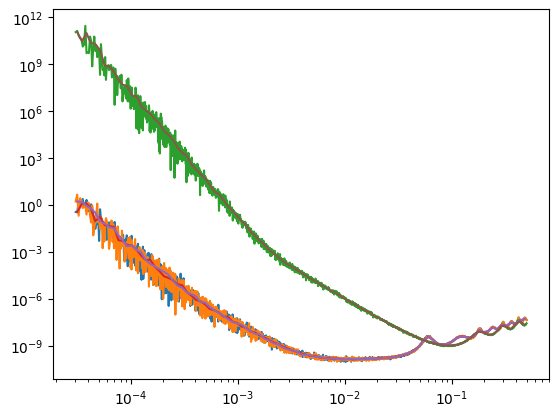

In [23]:
data_sample = high_cg_sim.sample(conditions={"z": np.array([-11.0, 0.0, 3.0, 15.0])})
low_cg_observation = low_cg_sim.generate_coarse_grained_data_from_sum(data_sample["full_quadratic_data_AET"])
high_cg_observation = high_cg_sim.generate_coarse_grained_data_from_sum(data_sample["full_quadratic_data_AET"])
plt.loglog(high_cg_sim.coarse_grained_f, high_cg_observation)
plt.loglog(low_cg_sim.coarse_grained_f, low_cg_observation)

In [24]:
def get_grid(N=1000, a_low=-11.42961597442627, a_high=-10.696080207824707, g_low=-0.7066106200218201, g_high=1.0477334260940552):
    a_samples = np.linspace(a_low, a_high, N)
    g_samples = np.linspace(g_low, g_high, N)
    ag_samples = np.array(np.meshgrid(a_samples, g_samples)).T.reshape(-1, 2)
    A_samples = np.ones(N)
    P_samples = np.ones(N)
    AP_samples = np.array(np.meshgrid(A_samples, P_samples)).T.reshape(-1, 2)
    return swyft.Samples(z=np.float32(np.concatenate((ag_samples, AP_samples), axis=1)))

prior_samples = get_grid(N=1000)

In [34]:
low_cg_logratios = trainer.infer(model=low_cg_network, A=swyft.Sample(data=low_cg_observation), B=prior_samples, batch_size=100000)
high_cg_logratios = trainer.infer(model=high_cg_network, A=swyft.Sample(data=high_cg_observation), B=prior_samples, batch_size=100000)

Predicting: 0it [00:00, ?it/s]

Predicting DataLoader 0: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


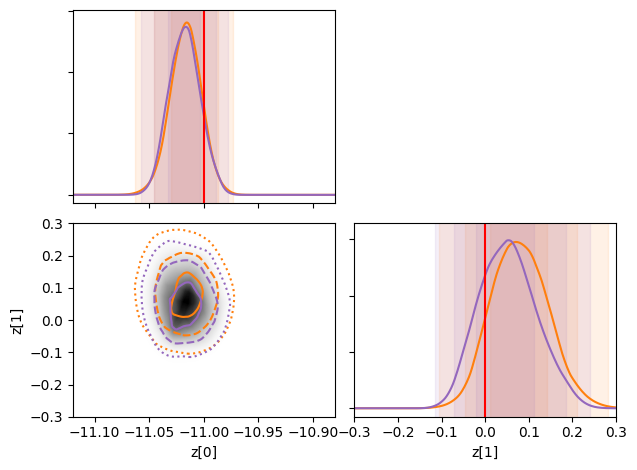

In [35]:
import corner
target_z = data_sample['z']
colors = ["black", "red", "green"]
lims = [[-11.12, -10.88], [-0.3, 0.3]]
swyft.plot_corner(low_cg_logratios, color='C1', parnames=low_cg_logratios.parnames[0], bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2), 1 - np.exp(-4.5)])
swyft.plot_corner(high_cg_logratios, color='C4', parnames=high_cg_logratios.parnames[0], bins=1000, cred_level=[1-np.exp(-0.5), 1-np.exp(-2), 1 - np.exp(-4.5)], fig=plt.gcf())
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(data_sample['z'][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

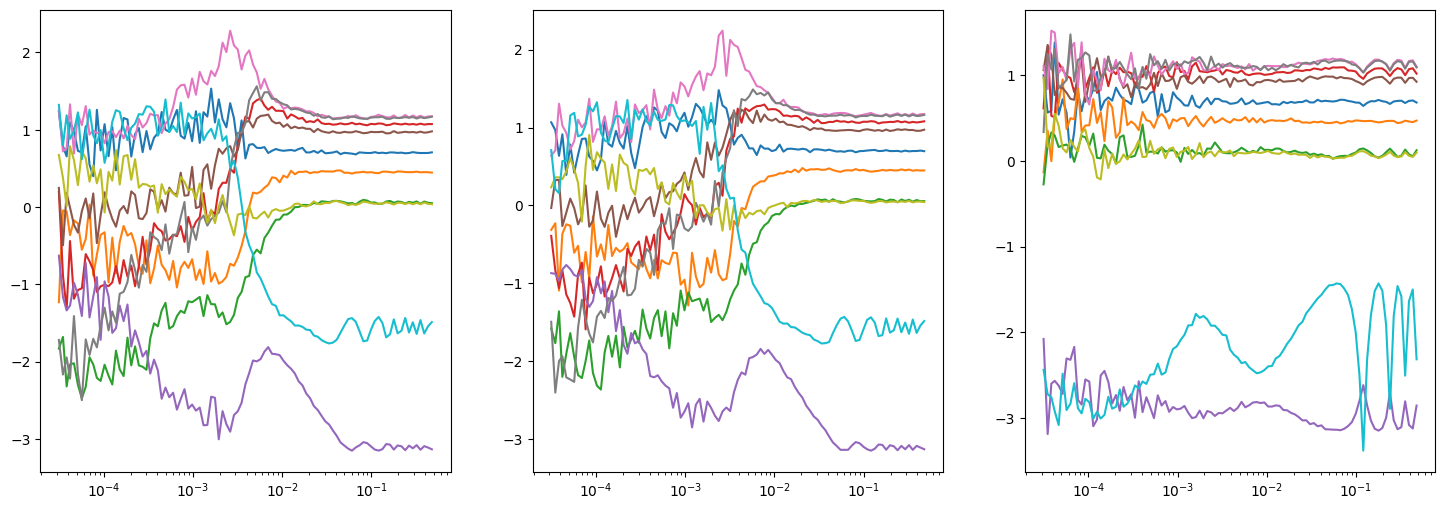

In [63]:
low_cg_network.eval()
fig = plt.figure(figsize=(18, 6))
for _ in range(10):
    data_sample = low_cg_sim.sample()
    low_cg_observation = low_cg_sim.generate_coarse_grained_data_from_sum(data_sample["full_quadratic_data_AET"])
    ax = plt.subplot(1, 3, 1)
    plt.semilogx(low_cg_sim.coarse_grained_f, low_cg_network.nl_AA(torch.log(torch.tensor(low_cg_observation[:, 0]))))
    ax = plt.subplot(1, 3, 2)
    plt.semilogx(low_cg_sim.coarse_grained_f, low_cg_network.nl_EE(torch.log(torch.tensor(low_cg_observation[:, 1]))))
    ax = plt.subplot(1, 3, 3)
    plt.semilogx(low_cg_sim.coarse_grained_f, low_cg_network.nl_TT(torch.log(torch.tensor(low_cg_observation[:, 2]))))

In [ ]:
low_cg_network.eval()
fig = plt.figure(figsize=(18, 6))
for _ in range(10):
    data_sample = low_cg_sim.sample()
    low_cg_observation = low_cg_sim.generate_coarse_grained_data_from_sum(data_sample["full_quadratic_data_AET"])
    ax = plt.subplot(1, 3, 1)
    plt.semilogx(low_cg_sim.coarse_grained_f, low_cg_network.nl_AA_no_log(torch.tensor(low_cg_observation[:, 0])))
    ax = plt.subplot(1, 3, 2)
    plt.semilogx(low_cg_sim.coarse_grained_f, low_cg_network.nl_EE_no_log(torch.tensor(low_cg_observation[:, 1])))
    ax = plt.subplot(1, 3, 3)
    plt.semilogx(low_cg_sim.coarse_grained_f, low_cg_network.nl_TT_no_log(torch.tensor(low_cg_observation[:, 2])))